# SPEECH EMOTION RECOGNITION

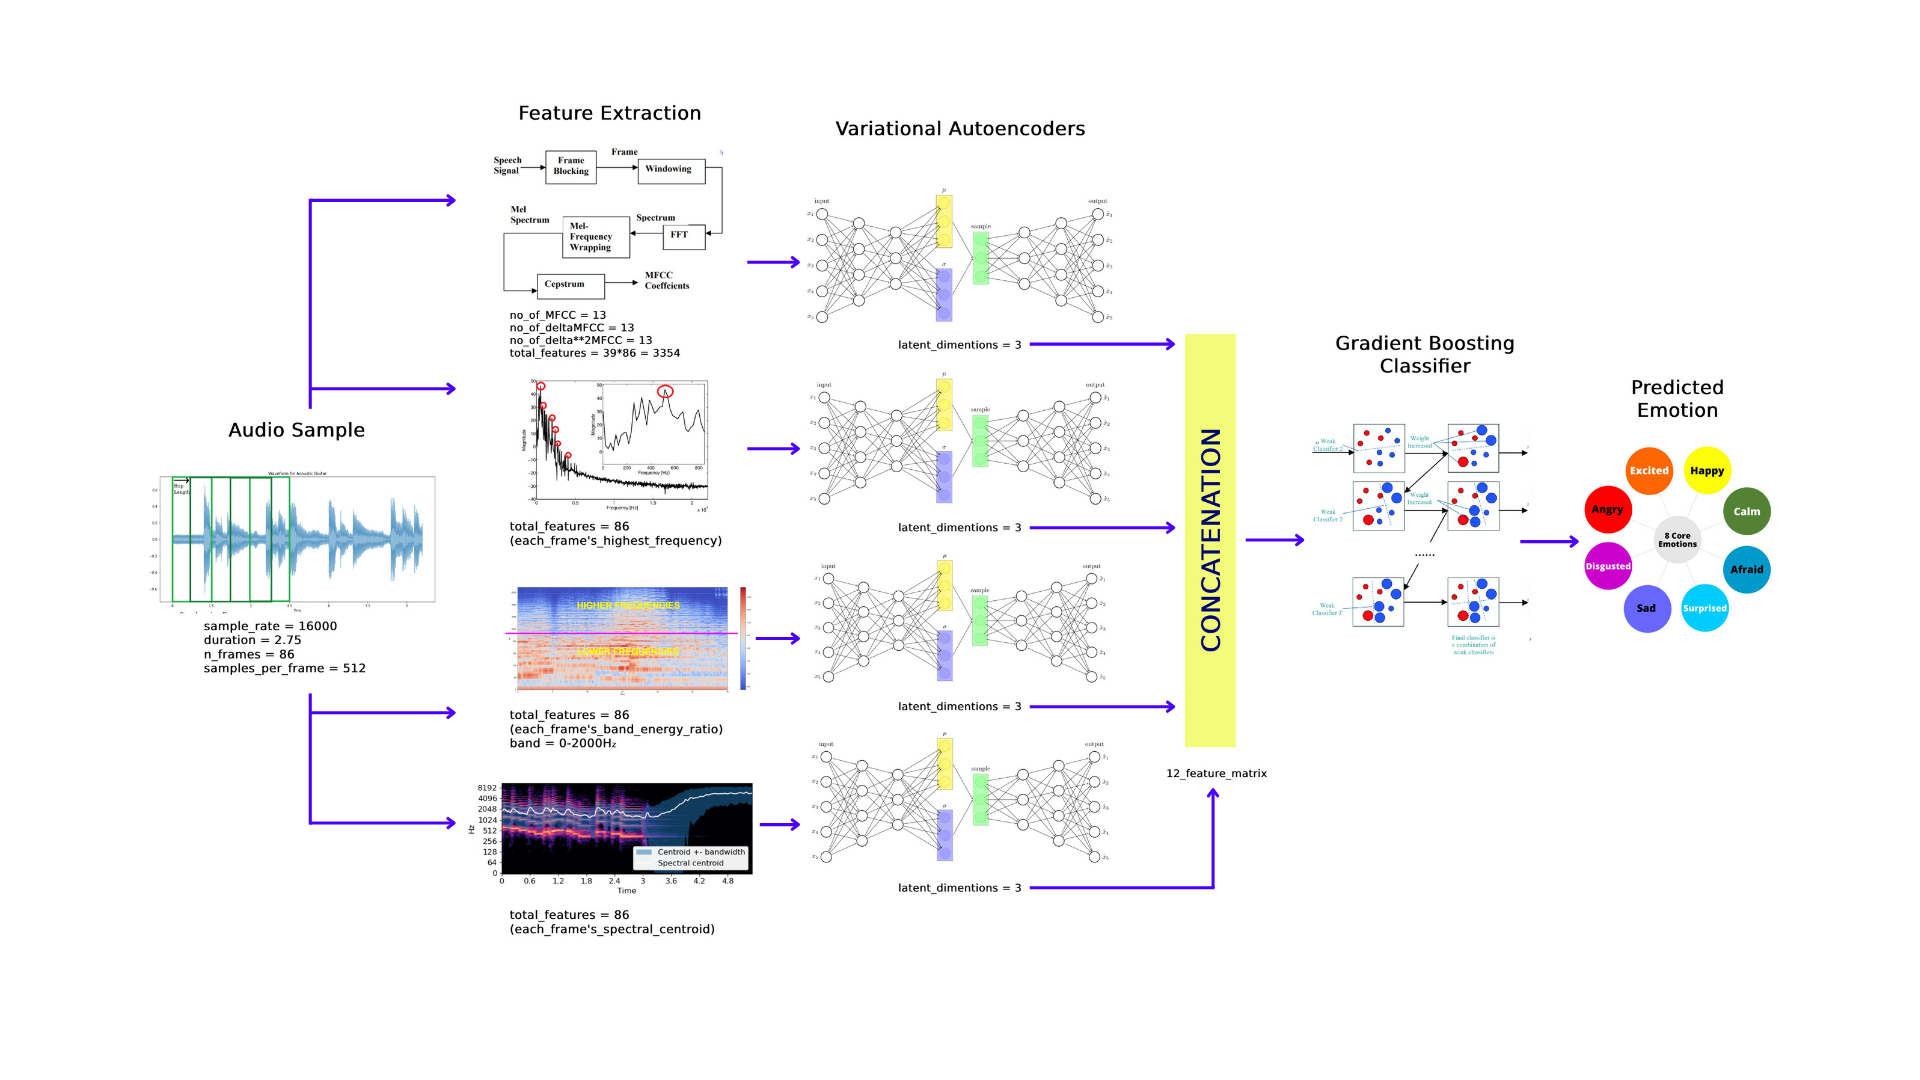

## 1 DATA PREPROCESSING

### 1.1 FEATURE SELECTION

### 1. MFCC FEATURES + (delta,delta**2)

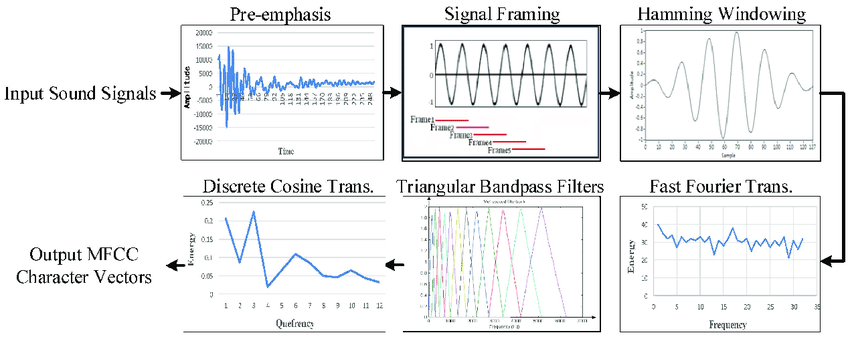

Mel-Frequency Cepstral Coefficients (MFCCs) are instrumental in detecting emotions from speech audio due to their ability to capture distinct spectral features related to emotions. In speech, various emotional states manifest through changes in pitch, timbre, and intensity. MFCCs effectively represent these characteristics by compressing the spectral information into a concise feature vector. For instance, changes in pitch, often associated with emotions like excitement or stress, are reflected in the distribution of MFCCs. Additionally, differences in vocal timbre, such as nasality or breathiness, are captured in the variations of MFCC values across frames of speech. By analyzing these MFCC patterns, machine learning algorithms can identify subtle emotional cues and classify the speaker's emotional state with high accuracy. Therefore, MFCCs serve as powerful descriptors for emotion recognition in speech audio, enabling applications ranging from sentiment analysis to virtual assistants' emotional responses.

### 2. PITCH/FUNDEMENTAL FREQUENCIES FEATURES

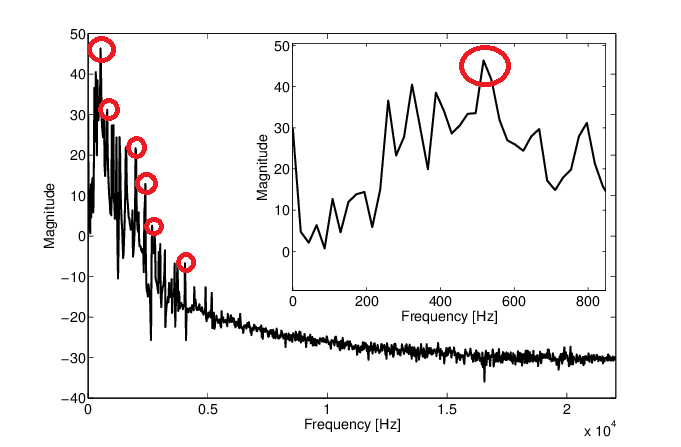

Pitch variation is a crucial aspect of emotional expression in speech. Emotions like happiness lead to higher pitch levels, conveying enthusiasm or joy. Conversely, feelings of sadness are reflected in lower pitch, conveying a sense of melancholy. Anger, on the other hand, results in sharp pitch fluctuations, indicating agitation or frustration. Pitch stability is associated with calmness or neutrality, reflecting composed demeanor. Understanding these pitch variations is essential for accurate emotional communication.

### 3. BAND ENERGY RATIO FEATURES

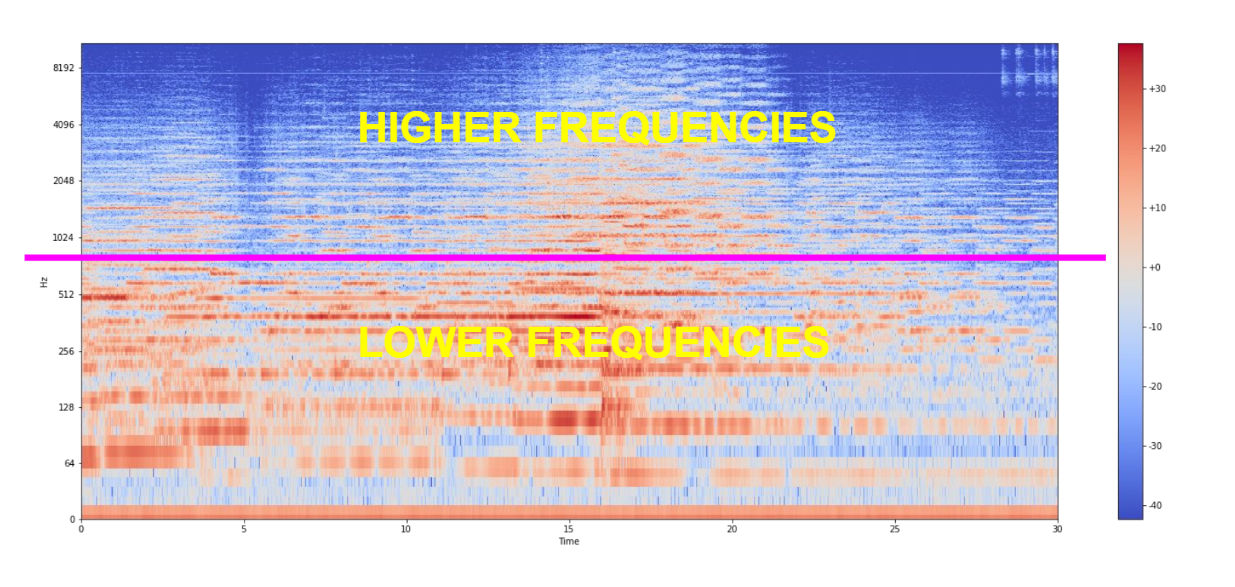

Emotional states often influence the distribution of energy across different frequency bands, resulting in characteristic patterns. For instance, emotions like excitement or anger tend to increase energy in higher frequency bands, reflecting heightened vocal intensity and sharper articulation. Conversely, emotions like sadness or relaxation may lead to a more even distribution of energy across the frequency spectrum, with emphasis on lower frequencies, indicating a softer and more subdued vocal expression. By computing the ratio of energy in specific frequency bands, we can derive features that capture these distinct patterns associated with various emotional states. Machine learning models trained on such features can effectively discern and classify emotions in speech audio, providing a nuanced understanding of the speaker's emotional demeanor.

#### 4. SPECTRAL CENTROID FEATURES

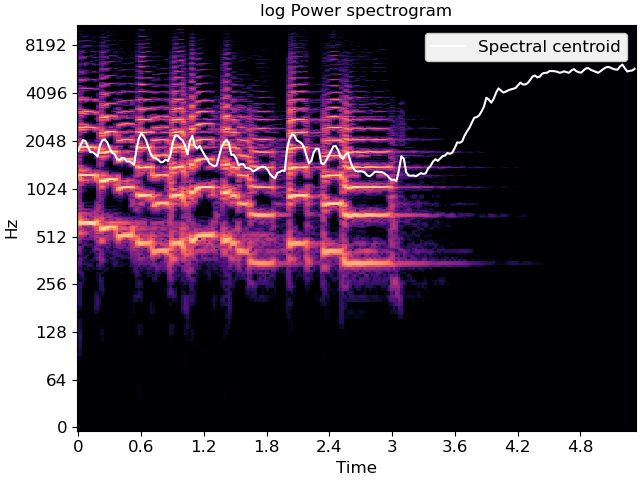

Emotional states significantly impact how energy is distributed across different frequencies, causing observable shifts in the spectral centroid. In moments of heightened arousal, such as excitement or anger, the spectral centroid tends to rise, signifying a concentration of energy toward higher frequencies. Conversely, emotions associated with lower arousal levels, like sadness or relaxation, often manifest in a lower spectral centroid, indicating a prevalence of energy in the lower frequency range. By examining these fluctuations in the spectral centroid across speech segments, machine learning algorithms can effectively discern and classify the speaker's emotional state. Spectral centroids thus serve as invaluable indicators in emotion detection systems, offering insights into the subtle nuances of vocal expression and providing deeper understanding of the speaker's emotional disposition.

### 1.2 FEATURE EXTRACTION

mfcc extraction:
librosa has been used for mfcc features and delta_mfcc, delta2_mfcc extraction sample rate of 16000, duration of 2.75 and hop lenght of 512 samples are taken. Shape of feature mfccs: (1440, 3354) represent the 39 (13 mfcc, 13 delta_mfcc, 13 delta2_mfcc) times all 86 frames (39*86 = 3354) each audio for all audio samples(1440)

pitch(fundemental frequencies) exxtraction:
we computes pitch features from audio using the PIPtrack algorithm. It iterates through time frames, identifies the dominant frequency's index, and retrieves the corresponding frequency value. If no frequency is detected, it appends 0.

Band energy ratio features:
First calculates the Band Energy Ratio (BER) from an audio signal using the Short-Time Fourier Transform (STFT). Then computes the STFT of the audio to get the frequency representation. The total energy across all frequencies is calculated. To avoid division by zero, any zero total energy values are replaced with a tiny number. The code then converts the minimum and maximum frequencies (fmin and fmax) to their corresponding FFT bin numbers. It computes the energy within this specific frequency band and then calculates the BER by dividing the band energy by the total energy. Finally, the BER values are flattened and appended to a feature list.

spectral centroid extraction:
Code calculates the spectral centroid of an audio signal using Librosa, indicating the "center of mass" of the spectrum. It flattens the 2D array of spectral centroid values into a 1D array for each time frame and appends these values to the spectral_centroids list .

In [1]:
import os
import librosa
import numpy as np

# Directory containing audio files
data_dir = r"C:\Users\Bim\Desktop\Deep learning\audio_detector\datasets"

mfccs = []
pitch = []
ber_features = []
spectral_centroids = []

# Define a specific frequency band for BER calculation
fmin, fmax = 0, 2000  # Example frequency band

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            audio, sr = librosa.load(file_path, sr=16000, duration=2.75)
            
            # Compute MFCC features
            mfcc_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)
            
            # Compute delta and delta-delta coefficients
            delta_mfccs = librosa.feature.delta(mfcc_features)
            delta2_mfccs = librosa.feature.delta(mfcc_features, order=2)
            
            # Combine MFCCs, delta, and delta-delta coefficients
            combined_features = np.vstack([mfcc_features, delta_mfccs, delta2_mfccs])
            mfccs.append(combined_features.flatten())  # Flatten the 2D array into 1D
            
            # Compute pitch features
            pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sr)
            pitch_collector = []
            for t in range(pitches.shape[1]):
                index = magnitudes[:, t].argmax()
                pitch_value = pitches[index, t]
                if pitch_value > 0:
                    pitch_collector.append(pitch_value)
                else:
                    pitch_collector.append(0)  # Append 0 if no pitch is found

            pitch.append(pitch_collector)

            # Compute Short-Time Fourier Transform (STFT)
            stft = np.abs(librosa.stft(audio))

            # Compute total energy
            total_energy = np.sum(stft ** 2, axis=0)

            total_energy[total_energy == 0] = np.finfo(float).eps  # Replace zero with a very small number

            # Convert frequencies to FFT bin numbers
            fmin_bin = int(np.floor(fmin * (stft.shape[0] / sr)))
            fmax_bin = int(np.ceil(fmax * (stft.shape[0] / sr)))

            # Compute the energy in the specified band
            band_energy = np.sum(stft[fmin_bin:fmax_bin, :] ** 2, axis=0)

            # Compute the BER for the band
            ber_value = band_energy / total_energy
            ber_features.append(ber_value.flatten())  # Flatten the array into 1D

            # Compute spectral centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
            spectral_centroids.append(spectral_centroid.flatten())  # Flatten the 2D array into 1D

# Convert lists to numpy arrays for further processing
mfccs = np.array(mfccs)
pitch = np.array(pitch)
ber_features = np.array(ber_features)
spectral_centroids = np.array(spectral_centroids)

print('Shape of feature mfccs:', mfccs.shape)
print('Shape of pitch features:', pitch.shape)
print('Shape of BER features:', ber_features.shape)
print('Shape of spectral centroid features:', spectral_centroids.shape)

Shape of feature mfccs: (1440, 3354)
Shape of pitch features: (1440, 86)
Shape of BER features: (1440, 86)
Shape of spectral centroid features: (1440, 86)


### Null or Inf value checking for avoid Zero/Inf division

In [2]:
print(np.isnan(mfccs).any() or np.isinf(mfccs).any())
print(np.isnan(pitch).any() or np.isinf(pitch).any())
print(np.isnan(ber_features).any() or np.isinf(ber_features).any())
print(np.isnan(spectral_centroids).any() or np.isinf(spectral_centroids).any())

False
False
False
False


### Extraction of corresponding labels of emotions:

### 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

In [3]:
import os
import numpy as np

# Path to the directory containing the audio files
directory = r"C:\Users\Bim\Desktop\Deep learning\audio_detector\datasets"

# Initialize an empty list to store emotion labels
y_labels = []

# Iterate over each file in the directory
for root, _, files in os.walk(directory):
    for file in files:
        if file.endswith('.wav'):
            # Split the filename by "-"
            parts = file.split("-")
            
            # Extract emotion from the filename
            emotion = int(parts[2])  # Emotion is at index 2
            
            # Append the emotion to the y_labels list
            y_labels.append(emotion)

# Print the extracted emotion labels
y_train = np.array(y_labels)
print(y_train[:20])

[1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3]


### 2. Data Modelling

### 2.1 Variational Autoencoder

![1 r1R0cxCnErWgE0P4Q-hI0Q.jpg](<attachment:1 r1R0cxCnErWgE0P4Q-hI0Q.jpg>)
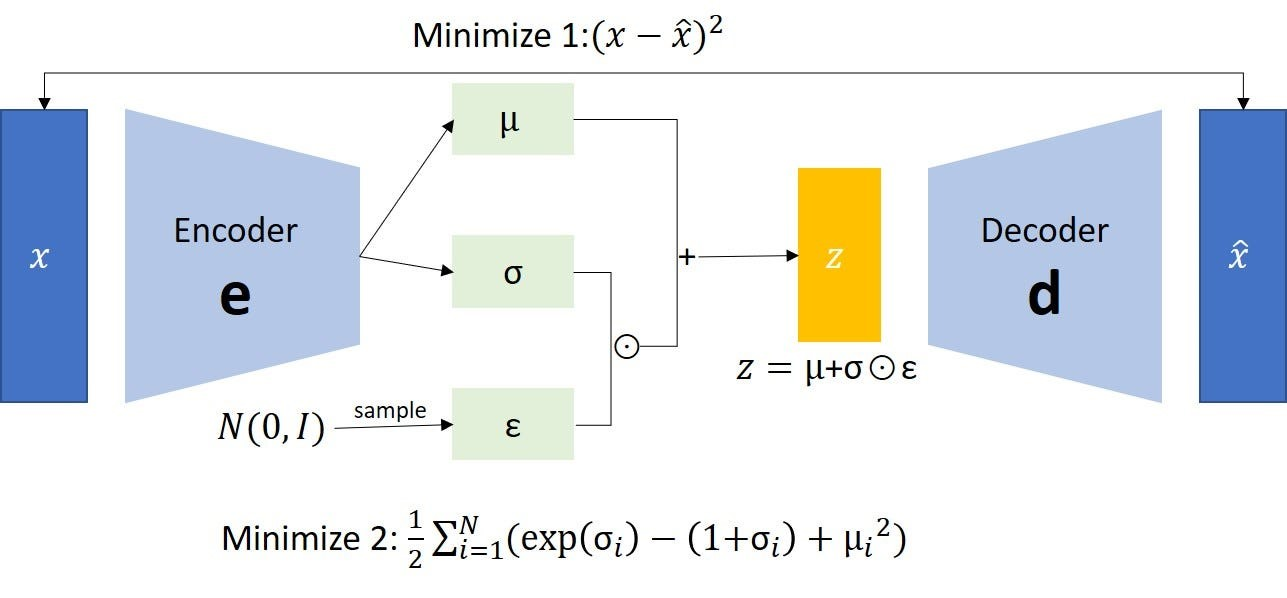

Variational Autoencoders (VAEs) are a type of generative model that learn to encode data into a lower-dimensional latent space and decode it back to the original space. They are used for generating new data samples that are similar to the training data and for tasks like anomaly detection, image generation, and data compression. Here's a concise overview of the VAE process:

### 1. Encoder (Recognition Model)

The encoder maps the input data to a latent space. Unlike traditional autoencoders, VAEs do not directly map the input to a single point in the latent space. Instead, they map the input to a distribution, typically a Gaussian distribution with a mean and a standard deviation. This is achieved using two neural networks that output the mean and the log of the variance.

$$
\mu, \log(\sigma^2)
$$

### 2. Latent Space (Sampling)

In the latent space, VAEs use the reparameterization trick to allow gradient descent optimization. Instead of sampling directly from the distribution, they sample an auxiliary variable from a standard normal distribution and then compute the latent variable using the mean and standard deviation.

$$
\mathbf{z} = \mu + \sigma \odot \epsilon
$$

### 3. Decoder (Generative Model)

The decoder maps the sampled latent variable back to the data space to reconstruct the input. The decoder is trained to produce outputs as close as possible to the original input data. This is typically done using neural networks that output the parameters of a probability distribution over the data space, such as the mean of a Gaussian distribution for continuous data or logits for categorical data.

### 4. Loss Function

The VAE is trained using a loss function that has two components:

- **Reconstruction Loss**: Measures how well the decoded samples match the input data. For continuous data, this is often the mean squared error or binary cross-entropy loss.
- **KL Divergence Loss**: Encourages the learned latent space distribution to be close to a prior distribution (usually a standard normal distribution). The KL divergence term measures the difference between the learned distribution and the prior distribution.

$$
D_{KL}(\mathcal{N}(\mu, \sigma^2) \parallel \mathcal{N}(0, I)) = -\frac{1}{2} \sum_{i=1}^{d} \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
$$

The total loss function combines these two terms to train the VAE.

$$
\text{Loss} = \text{Reconstruction Loss} + \text{KL Divergence Loss}
$$

In [4]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [23]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(reconstruction_loss))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def save_encoder(self, filename):
        """Saves the weights of the VAE's encoder to a file.

        Args:
            filename: The filename to save the weights to.
        """
        self.encoder.save_weights(filename)

### 2.2 MFCC VAE

In [24]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Lambda, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers


latent_dim = 3

# Define the input shape
input_shape = (3354,)  # Update with your actual input shape

# Input layer
input_layer = Input(shape=input_shape)

x = Dense(512,activation='relu')(input_layer)

x = Dense(64,activation='relu')(x)

x = Dense(32,activation='relu')(x)

x = Dense(16,activation='relu')(x)

# Dense layer
x = Dense(latent_dim + latent_dim)(x)

z_mean = Dense(latent_dim, name="z_mean",kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)

z_log_var = Dense(latent_dim, name="z_log_var",kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)

z = Sampling()([z_mean, z_log_var])

encoder_MFCC = Model(input_layer, [z_mean, z_log_var, z], name="encoder")

encoder_MFCC.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 3354)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 512)       │  1,717,760 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │     32,832 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 32)        │      2,080 │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 16)        │        528 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 6)         │        102 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         21 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │         21 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_4          │ (None, 3)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,753,344 (6.69 MB)

 Trainable params: 1,753,344 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, ReLU, UpSampling2D, Softmax
from tensorflow.keras.models import Model

input_shape = (latent_dim,) 

# Input layer
input_layer = Input(shape=input_shape)

x = Dense(512, activation='relu')(input_layer)
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(3354)(x)


# Define the model
decoder_MFCC = Model(inputs=input_layer, outputs=x)

# Display model summary
decoder_MFCC.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3354)           │     3,437,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,227,866 (16.13 MB)

 Trainable params: 4,227,866 (16.13 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
vae_mfcc = VAE(encoder_MFCC, decoder_MFCC)
vae_mfcc.compile(optimizer=keras.optimizers.Adam())
vae_mfcc.fit(mfccs, epochs=10)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - kl_loss: 54.4849 - loss: -8026.4106 - reconstruction_loss: -8090.7788 - total_loss: -8481.0381
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - kl_loss: 37.4362 - loss: -8720.3438 - reconstruction_loss: -8758.5732 - total_loss: -8756.8301
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - kl_loss: 68.1239 - loss: -8708.4395 - reconstruction_loss: -8775.2734 - total_loss: -8649.1191
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - kl_loss: 8.5666 - loss: -8815.2471 - reconstruction_loss: -8823.2949 - total_loss: -8791.3760
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - kl_loss: 7.3146 - loss: -8770.7246 - reconstruction_loss: -8779.2227 - total_loss: -8825.1758
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - kl_loss: 2.7047 - loss: -8884.9072 - reconstruction_loss: -8886.8203 - total_loss: -8848.5137
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - kl_loss: 1.7958 - loss: -8858.1934 - reconstruction_loss: -885

In [28]:
import plotly.graph_objects as go

def plot_label_clusters(vae, data, labels):
    # Compute the 3D latent representations
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    
    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=z_mean[:, 0],
        y=z_mean[:, 1],
        z=z_mean[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=labels,
            colorscale='Viridis'
        )
    )])
    
    # Update layout
    fig.update_layout(scene=dict(
        xaxis_title='Z[0]',
        yaxis_title='Z[1]',
        zaxis_title='Z[2]'
    ))
    
    # Show plot
    fig.show()

# Call the function with your VAE model and data
plot_label_clusters(vae_mfcc, mfccs, y_labels)

### 2.3 PITCH VAE

In [29]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Lambda, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers


latent_dim = 3

input_shape = (86,)

# Input layer
input_layer = Input(shape=input_shape)

x = Dense(86,activation='relu')(input_layer)

x = Dense(64,activation='relu')(x)

x = Dense(64,activation='relu')(x)

x = Dense(32,activation='relu')(x)

x = Dense(latent_dim + latent_dim)(x)

z_mean = Dense(latent_dim, name="z_mean",kernel_initializer=initializers.RandomNormal(stddev=0.001))(x)

z_log_var = Dense(latent_dim, name="z_log_var",kernel_initializer=initializers.RandomNormal(stddev=0.001))(x)

z = Sampling()([z_mean, z_log_var])

encoder_pitch = Model(input_layer, [z_mean, z_log_var, z], name="encoder")

encoder_pitch.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 86)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 86)        │      7,482 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 64)        │      5,568 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 64)        │      4,160 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 32)        │      2,080 │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 6)         │        198 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         21 │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │         21 │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_5          │ (None, 3)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,530 (76.29 KB)

 Trainable params: 19,530 (76.29 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, ReLU, UpSampling2D, Softmax
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (latent_dim,)  # Update with the actual latent dimension

# Input layer
input_layer = Input(shape=input_shape)

# Dense layer
x = Dense(32, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(86)(x)


# Define the model
decoder_pitch = Model(inputs=input_layer, outputs=x)

# Display model summary
decoder_pitch.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 86)             │         5,590 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,990 (46.84 KB)

 Trainable params: 11,990 (46.84 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
vae_pitch = VAE(encoder_pitch, decoder_pitch)
vae_pitch.compile(optimizer=keras.optimizers.Adam())
vae_pitch.fit(pitch, epochs=50)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 2741618.7500 - loss: 2792916.0000 - reconstruction_loss: 10139.5059 - total_loss: 899680.0000
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1958.6213 - loss: -151543.1875 - reconstruction_loss: -153606.8281 - total_loss: -156374.6250
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 931.0396 - loss: -162601.7656 - reconstruction_loss: -163453.3906 - total_loss: -158948.6094
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 620.7610 - loss: -163061.1406 - reconstruction_loss: -163740.0000 - total_loss: -165734.3281
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 368.5113 - loss: -166406.3906 - reconstruction_loss: -166789.4844 - total_loss: -167076.5938
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 388.9431 - loss: -166974.9062 - reconstruction_loss: -167366.2656 - total_loss: -167086.0625
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 891.1477 - lo

In [32]:
plot_label_clusters(vae_pitch, pitch, y_labels)

### 2.4 BAND ENERGY RATIO VAE

In [41]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers


latent_dim = 3

# Define the input shape
input_shape = (86,)  # Update with your actual input shape

# Input layer
input_layer = Input(shape=input_shape)

x = Dense(128,activation='relu')(input_layer)

x = Dense(64,activation='relu')(x)

x = Dense(32,activation='relu')(x)

x = Dense(8,activation='relu')(x)

# Dense layer
x = Dense(latent_dim + latent_dim)(x)

z_mean = Dense(latent_dim, name="z_mean",kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)

z_log_var = Dense(latent_dim, name="z_log_var",kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)

z = Sampling()([z_mean, z_log_var])

encoder_ber = Model(input_layer, [z_mean, z_log_var, z], name="encoder")

encoder_ber.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 86)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 128)       │     11,136 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 64)        │      8,256 │ dense_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 32)        │      2,080 │ dense_73[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 8)         │        264 │ dense_74[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 6)         │         54 │ dense_75[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         21 │ dense_76[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │         21 │ dense_76[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_8          │ (None, 3)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,832 (85.28 KB)

 Trainable params: 21,832 (85.28 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (latent_dim,)  # Update with the actual latent dimension

# Input layer
input_layer = Input(shape=input_shape)

# Dense layer
x = Dense(64, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(86)(x)


# Define the model
decoder_ber = Model(inputs=input_layer, outputs=x)

# Display model summary
decoder_ber.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 86)             │         5,590 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,166 (55.34 KB)

 Trainable params: 14,166 (55.34 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
vae_ber = VAE(encoder_ber, decoder_ber)
vae_ber.compile(optimizer=keras.optimizers.Adam())
vae_ber.fit(ber_features, epochs=50)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 5.3619e-04 - loss: 161.4754 - reconstruction_loss: 160.8094 - total_loss: 130.8606
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0023 - loss: 79.4863 - reconstruction_loss: 79.3210 - total_loss: 71.9877
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0381 - loss: 54.2172 - reconstruction_loss: 54.1024 - total_loss: 50.6893
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0145 - loss: 44.9385 - reconstruction_loss: 44.8799 - total_loss: 42.9088
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0043 - loss: 39.7828 - reconstruction_loss: 39.7667 - total_loss: 39.2374
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0278 - loss: 38.7249 - reconstruction_loss: 38.6882 - total_loss: 38.3129
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0482 - loss: 37.3418 - reconstruction_loss: 37.2959 - total_loss: 37.4468
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━

In [44]:
plot_label_clusters(vae_ber, ber_features, y_labels)

#### 2.5 SPECTRAL CENTROID VAE

In [53]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers


latent_dim = 3

# Define the input shape
input_shape = (86,)  # Update with your actual input shape

# Input layer
input_layer = Input(shape=input_shape)

x = Dense(86,activation='relu')(input_layer)

x = Dense(64,activation='relu')(x)

x = Dense(32,activation='relu')(x)

x = Dense(8,activation='relu')(x)

# Dense layer
x = Dense(latent_dim + latent_dim)(x)

z_mean = Dense(latent_dim, name="z_mean",kernel_initializer=initializers.RandomNormal(stddev=0.001))(x)

z_log_var = Dense(latent_dim, name="z_log_var",kernel_initializer=initializers.RandomNormal(stddev=0.001))(x)

z = Sampling()([z_mean, z_log_var])

encoder_sc = Model(input_layer, [z_mean, z_log_var, z], name="encoder")

encoder_sc.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 86)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 86)        │      7,482 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 64)        │      5,568 │ dense_99[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_101 (Dense)   │ (None, 32)        │      2,080 │ dense_100[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_102 (Dense)   │ (None, 8)         │        264 │ dense_101[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 6)         │         54 │ dense_102[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         21 │ dense_103[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │         21 │ dense_103[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_11         │ (None, 3)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,490 (60.51 KB)

 Trainable params: 15,490 (60.51 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (latent_dim,)  # Update with the actual latent dimension

# Input layer
input_layer = Input(shape=input_shape)

# Dense layer
x = Dense(32, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(86)(x)


# Define the model
decoder_sc = Model(inputs=input_layer, outputs=x)

# Display model summary
decoder_sc.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 86)             │         5,590 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,990 (46.84 KB)

 Trainable params: 11,990 (46.84 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
vae_sc = VAE(encoder_sc, decoder_sc)
vae_sc.compile(optimizer=keras.optimizers.Adam())
vae_sc.fit(spectral_centroids, epochs=30)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 35744.5039 - loss: -11512.7754 - reconstruction_loss: -54245.3008 - total_loss: -332961.7188
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 8078.4419 - loss: -631276.6250 - reconstruction_loss: -639389.2500 - total_loss: -632849.8750
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1295.9772 - loss: -640292.3125 - reconstruction_loss: -641520.3750 - total_loss: -637168.9375
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3506.7334 - loss: -635793.6250 - reconstruction_loss: -639285.8125 - total_loss: -635124.5625
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 2956.3062 - loss: -634879.0000 - reconstruction_loss: -637877.8125 - total_loss: -636834.0625
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1356.1248 - loss: -639244.9375 - reconstruction_loss: -640574.5625 - total_loss: -638027.8125
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 891.2225 -

In [56]:
plot_label_clusters(vae_sc, spectral_centroids, y_labels)

### 2.6 LATENT REPRESENTATIONS CONCATINATION

Here uses four trained Variational Autoencoders (VAEs) to encode different audio features—MFCCs, pitch, BER features, and spectral centroids—into their respective latent representations. Specifically, the latent vectors X_latent_mfcc, X_latent_p, X_latent_b, and X_latent_s are obtained by passing mfccs, pitch, ber_features, and spectral_centroids through their corresponding VAE encoders. An empty list X_train_reshaped is initialized, and an iteration is performed through 1440 samples. In each iteration, the latent vectors of the four features for the current sample are concatenated and appended to X_train_reshaped. Finally, X_train_reshaped is converted into a NumPy array for further processing.

In [57]:
X_latent_mfcc,_,_ = vae_mfcc.encoder.predict(mfccs, verbose=0)
X_latent_p,_,_ = vae_pitch.encoder.predict(pitch, verbose=0)
X_latent_b,_,_ = vae_ber.encoder.predict(ber_features, verbose=0)
X_latent_s,_,_ = vae_sc.encoder.predict(spectral_centroids, verbose=0)

In [58]:
X_train_reshaped = []
for i in range(1440):
    x_train_loop = np.concatenate((X_latent_mfcc[i],X_latent_p[i],X_latent_b[i],X_latent_s[i]))
    X_train_reshaped.append(x_train_loop)
X_train_reshaped = np.array(X_train_reshaped)
X_train_reshaped.shape

(1440, 12)

### 2.7 TRAIN/TEST SEPARATION

In [59]:
from sklearn.model_selection import train_test_split

X_train_classifier,X_test_classifier,y_train_classifier,y_test_classifier = train_test_split(X_train_reshaped, y_train, test_size=0.20, random_state=42)

In [60]:
print(X_train_classifier.shape)
print(y_train_classifier.shape)
print(X_test_classifier.shape)
print(y_test_classifier.shape)

(1152, 12)
(1152,)
(288, 12)
(288,)


### 2.8 APPLY CLASSIFIER 

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

In [62]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, min_samples_split=2, max_depth=10).fit(X_train_classifier, y_train_classifier)

### 2.9 MODEL PERFORMANCE

In [63]:
y_true = y_test_classifier
y_pred = clf.predict(X_test_classifier)
y_pred

array([6, 2, 8, 4, 7, 3, 2, 8, 8, 2, 8, 8, 3, 6, 4, 7, 6, 6, 2, 4, 6, 2,
       4, 2, 8, 4, 6, 3, 7, 7, 8, 6, 8, 3, 2, 7, 6, 5, 6, 3, 2, 2, 2, 5,
       3, 2, 2, 2, 6, 8, 7, 8, 6, 6, 2, 3, 2, 8, 4, 7, 2, 7, 6, 5, 6, 3,
       3, 3, 2, 4, 3, 1, 1, 5, 7, 2, 5, 8, 7, 7, 3, 8, 6, 2, 8, 5, 5, 2,
       2, 2, 1, 4, 6, 4, 2, 7, 3, 3, 2, 8, 2, 4, 5, 3, 1, 8, 4, 1, 3, 3,
       8, 5, 1, 4, 7, 5, 6, 5, 6, 6, 5, 2, 6, 5, 1, 5, 8, 2, 6, 3, 8, 6,
       2, 3, 4, 2, 2, 2, 5, 5, 7, 7, 4, 7, 6, 3, 5, 4, 3, 5, 3, 4, 2, 8,
       3, 2, 5, 2, 2, 6, 2, 7, 6, 2, 2, 8, 5, 2, 3, 3, 3, 6, 5, 2, 3, 4,
       7, 3, 6, 6, 6, 6, 7, 3, 2, 8, 2, 5, 5, 4, 2, 6, 2, 2, 2, 7, 7, 6,
       6, 7, 7, 2, 8, 7, 3, 8, 2, 4, 7, 5, 6, 7, 3, 6, 2, 2, 1, 5, 3, 3,
       4, 6, 3, 4, 4, 2, 2, 3, 7, 2, 1, 8, 4, 7, 3, 8, 3, 7, 3, 2, 7, 3,
       4, 2, 7, 6, 2, 7, 3, 7, 5, 2, 7, 2, 5, 6, 6, 4, 4, 2, 1, 6, 2, 4,
       6, 2, 5, 5, 4, 1, 7, 2, 6, 1, 4, 6, 3, 8, 6, 4, 6, 8, 1, 7, 4, 3,
       3, 1])

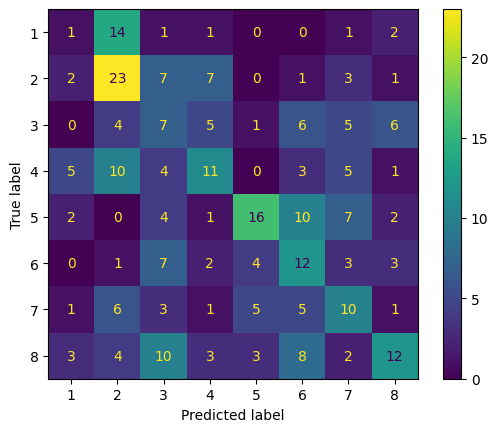

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred
)

In [65]:
from sklearn.metrics import accuracy_score

print("Accuracy score of the model is :", round(accuracy_score(y_true, y_pred),3))

Accuracy score of the model is : 0.319
